In [1]:
import warnings
warnings.filterwarnings('ignore')


## Compariston of different user interactions on different data sets

Train F1 Score: 0.8540731482056073, Test F1 Score: 0.8629625059637782


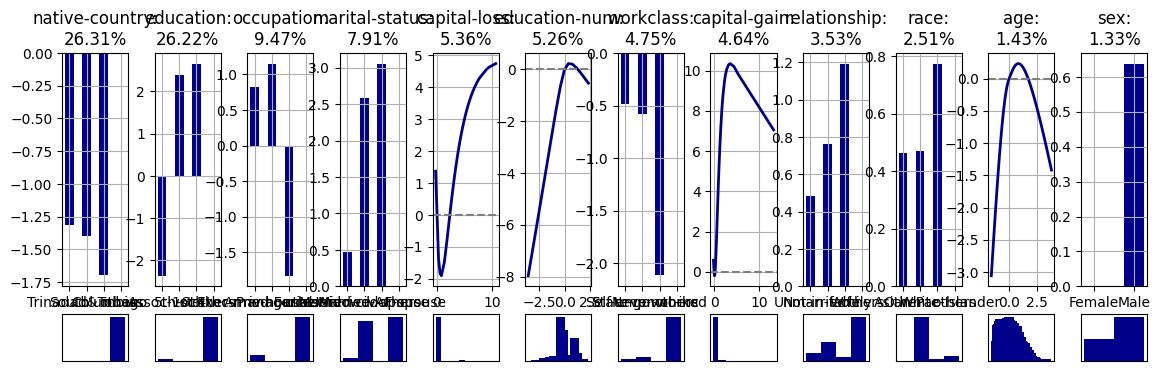

No synthetic points


KeyError: 'education_num'

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter
import torch

if __name__ == "__main__":
    
    # Load the old model and split the data 
    
    # TODO: Dictionary mit key=dataset und values=features to change erstellen
    
    X_train, X_test, y_train, y_test, task = load_and_preprocess_data("adult")
    #X_train, X_test, y_train, y_test, task = load_and_preprocess_data("bike")

    #X_train, X_test, y_train, y_test, task = load_and_preprocess_data("titanic")

    adapter = ModelAdapter(task)
    adapter.fit(X_train, y_train)

    # Calculate and print mean squared error
    y_train_pred = adapter.predict(X_train)
    y_test_pred = adapter.predict(X_test)

    if task == "regression":
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
    else:
        f1_train = f1_score(y_train, y_train_pred, average='weighted')
        f1_test = f1_score(y_test, y_test_pred, average='weighted')
        print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")



    #features_to_change = ['sepal length (cm)', 'sepal width (cm)',  'petal length (cm)', 'petal width (cm)']
    ##features_to_change = ['sepal length (cm)', 'sepal width (cm)']
    #features_to_change = ['petal length (cm)', 'petal width (cm)']

    #features_to_change = ['petal width (cm)']
    #features_to_change = ['temp']
    #features_to_change = ['bmi', 'bp', 'sex']
    #features_to_change = ['Age', 'Pclass', 'Sex']
    features_to_change = ['education-num', 'workclass', 'marital-status', 'capital-loss']

    # Load feature data
    shape_functions_dict = adapter.model.get_shape_functions_as_dict()
    #adapter.plot_single(plot_by_list=['age', 'bmi', 'bp', 'sex', 's1', 's2'])
    #adapter.plot_single(plot_by_list=features_to_change)
    adapter.model.plot_single(show_n=12)
    print(adapter.model)
    # this part is already given in the flask application
    feature_current_state = {}
    for feature in (
            shape_functions_dict):
        name = feature['name']
        y_value = feature['y']
        feature_current_state[name] = y_value

    updated_data = {}


    for feature in shape_functions_dict:
        name = feature['name']
        x_values = feature['x']
        if name in features_to_change:
            # Simulate user input (by setting negative values to 0); in flask app just use feature_current_state
            if feature["datatype"] == "categorical":
                user_input = -1.5

                feature_current_state[name][0] = -2
                y_values = np.array(feature_current_state[name])
                #y_values = {'x': x_values, 'y': np.where(np.array(feature_current_state[name]) < 0,
                #                                         -2, np.array(feature_current_state[name])), 'datatype': 'categorical'}
                #y_values = np.array(feature_current_state[name])
            else:
                #y_values = np.where(np.array(feature_current_state[name]) < 0, -10, feature_current_state[name])
                y_values = np.array(feature_current_state[name])
                #y_values = np.where(y_values < 0, -3, y_values)
                #updated_data[name] = {'x': x_values.tolist(), 'y': adjusted_y_values.tolist(),
                #                      'datatype': 'numerical'}
                synthetic_data_points_nr = 0
                new_x_values = []
                new_y_values = []
                #transformed_y_values = np.where(y_values < 0.8, 0.9, y_values)
                transformed_y_values = np.where(y_values < 0, -2, y_values)
                if synthetic_data_points_nr > 0:
                    for i in range(len(x_values) - 1):
                        new_x_values.append(x_values[i])
                        new_y_values.append(transformed_y_values[i])
                        # Calculate steps for synthetic points
                        x_step = (x_values[i + 1] - x_values[i]) / (synthetic_data_points_nr + 1)
                        y_step = (transformed_y_values[i + 1] - transformed_y_values[i]) / (synthetic_data_points_nr + 1)
                        #
                        for j in range(1, synthetic_data_points_nr + 1):
                            synthetic_x = x_values[i] + j * x_step
                            synthetic_y = transformed_y_values[i] + j * y_step if transformed_y_values[i] != -10 else -10
                            new_x_values.append(synthetic_x)
                            new_y_values.append(synthetic_y)
                #
                #    # Don't forget to add the last original point
                    new_x_values.append(x_values[-1])
                    new_y_values.append(transformed_y_values[-1])
                    x_values = new_x_values
                    y_values= new_y_values
                else:
                     y_values = transformed_y_values
                     print("No synthetic points")
                #                       'datatype': 'numerical'}
        else:
            # Use the original 'y' values from shape_functions_dict if there is no user change
            y_values = feature['y']

        if feature['datatype'] == 'numerical':
            updated_data[name] = {'x': x_values, 'y': y_values, 'datatype': 'numerical'}
        else:
            updated_data[name] = {'x': x_values, 'y': y_values, 'datatype': 'categorical'}


    # ändern, wenn es in Wesite Code kommt: Nur die Änderungen von features_to_change in feature_current_state übernehmen
    # updated_data == feature-current_state; anpassen für kategorische Werte
    # Als erstes möchte ich eine Liste von features to change übergeben
    # spline, retrain_feature
    adapter = adapter.adapt(features_to_change, updated_data, "retrain_feature", X_train, y_train)

    y_train_pred = adapter.predict(X_train)
    y_test_pred = adapter.predict(X_test)
    if task == "regression":
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
    else:
        f1_train = f1_score(y_train, y_train_pred, average='weighted')
        f1_test = f1_score(y_test, y_test_pred, average='weighted')
        print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

    adapter.plot_single(plot_by_list=features_to_change)



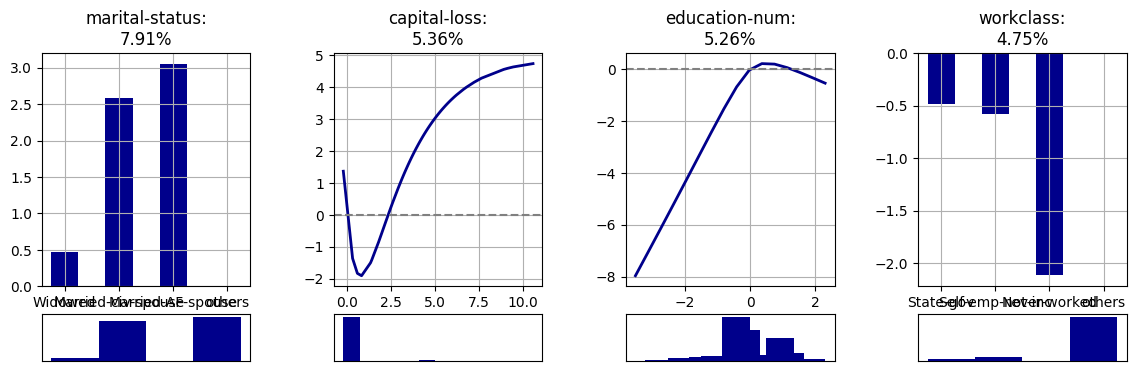

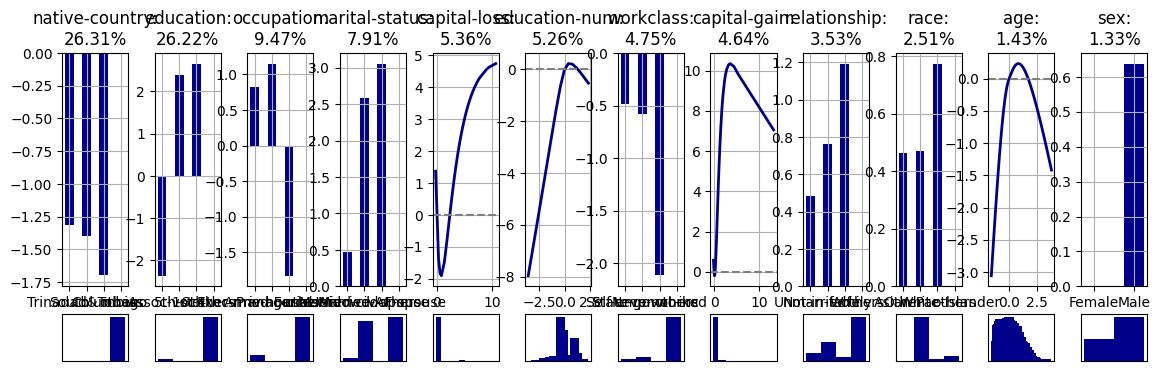

No synthetic points
No synthetic points


C:\Users\jfill\PycharmProjects\Masterthesis\Dashboard\model_adapter.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tilde = torch.sqrt(torch.tensor(0.5)) * (torch.tensor((y - y_hat), dtype=torch.float64))


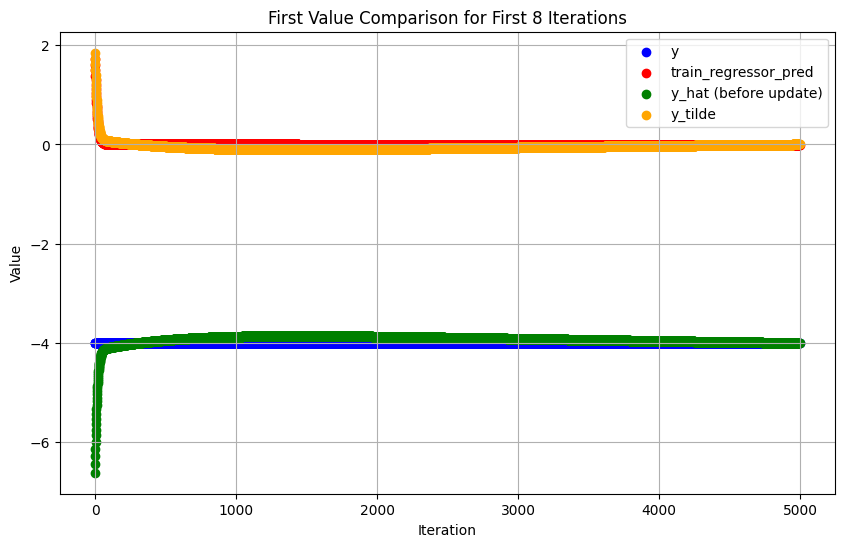

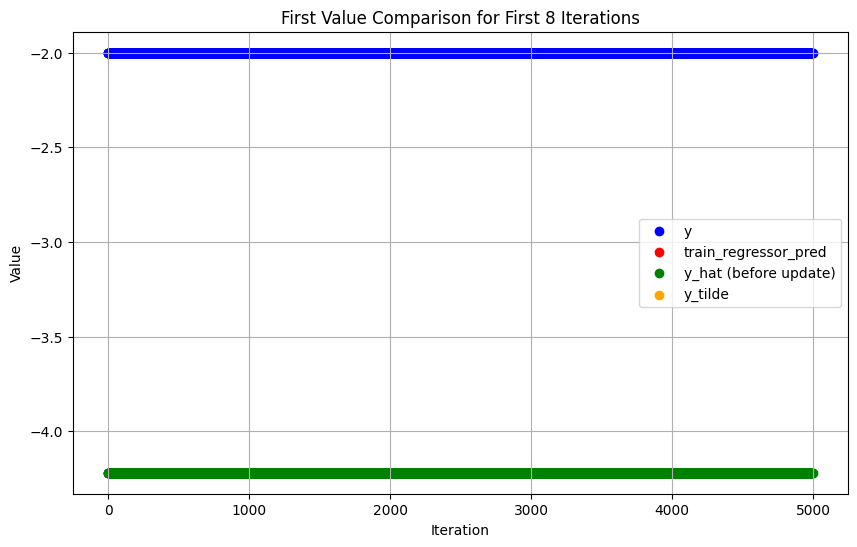

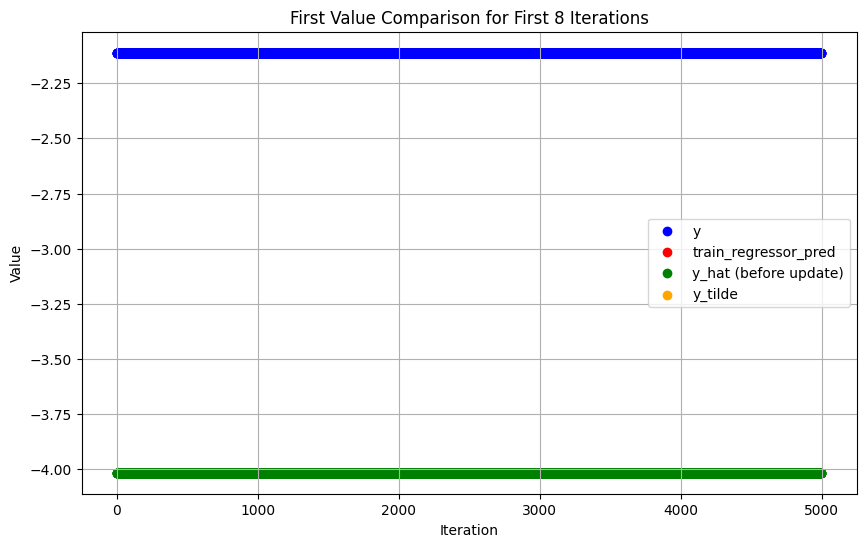

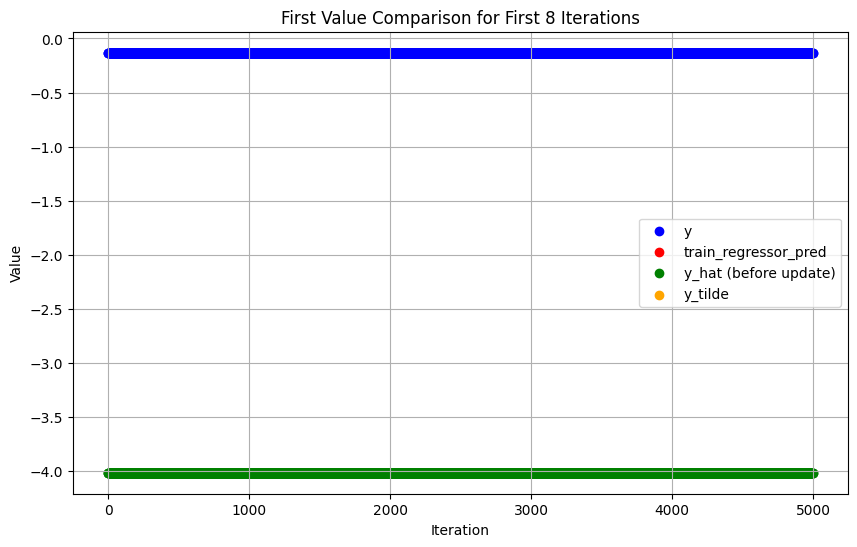

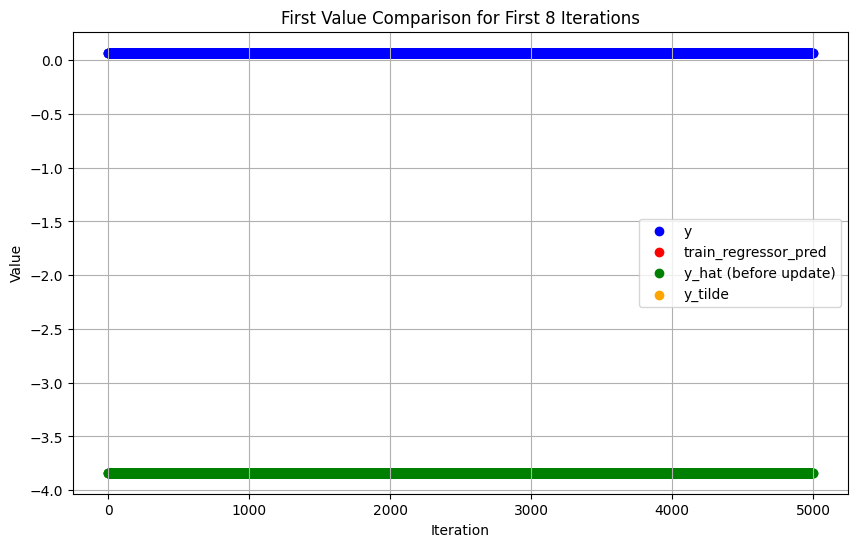

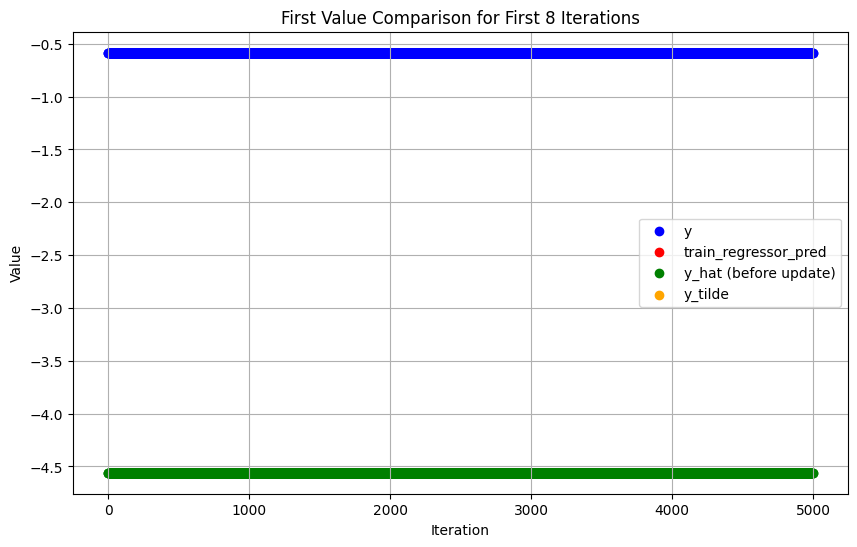

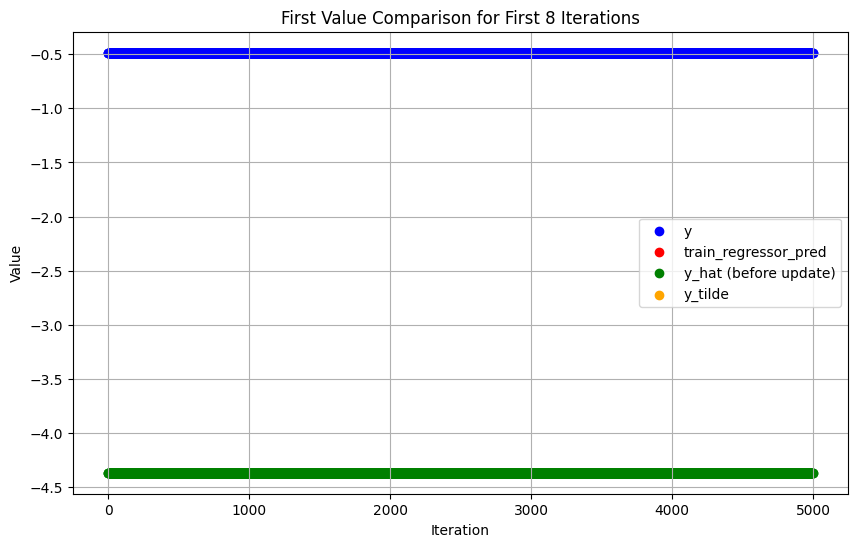

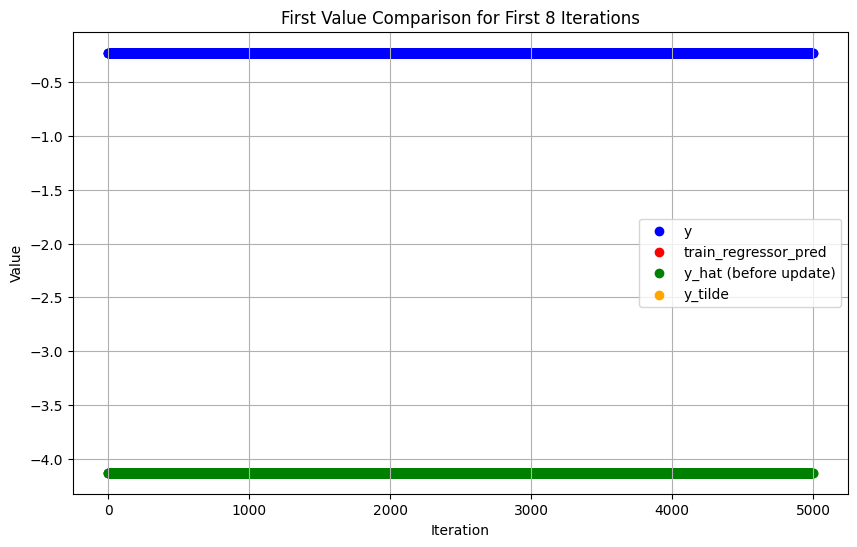

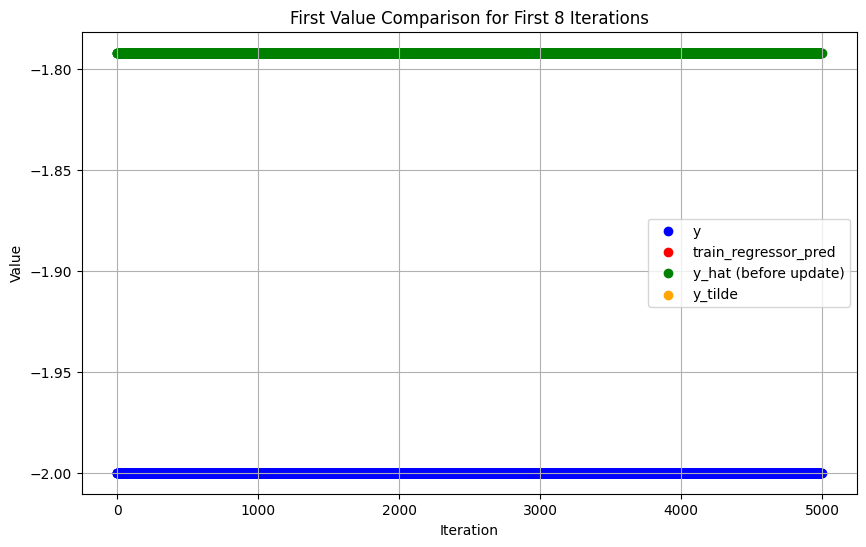

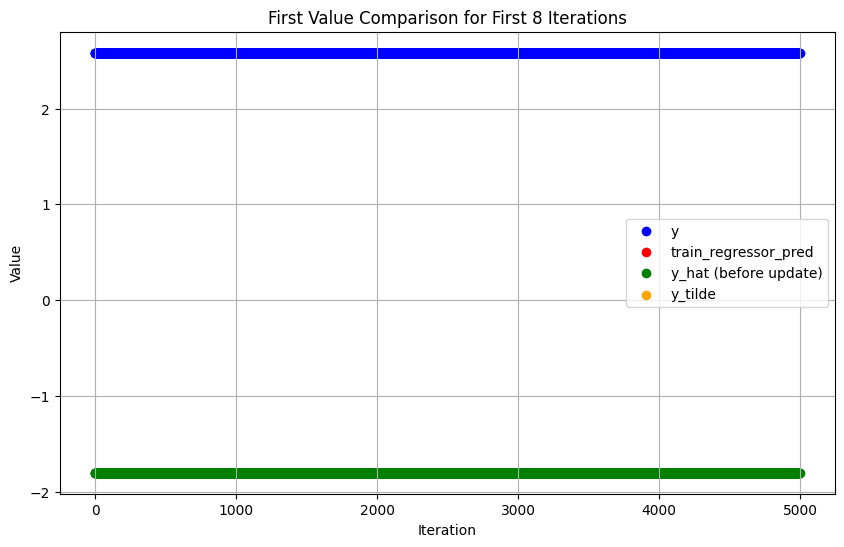

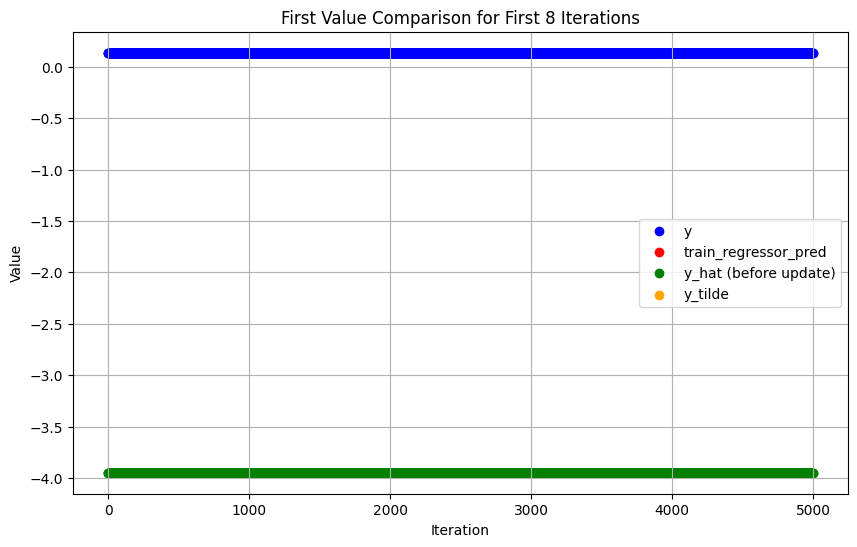

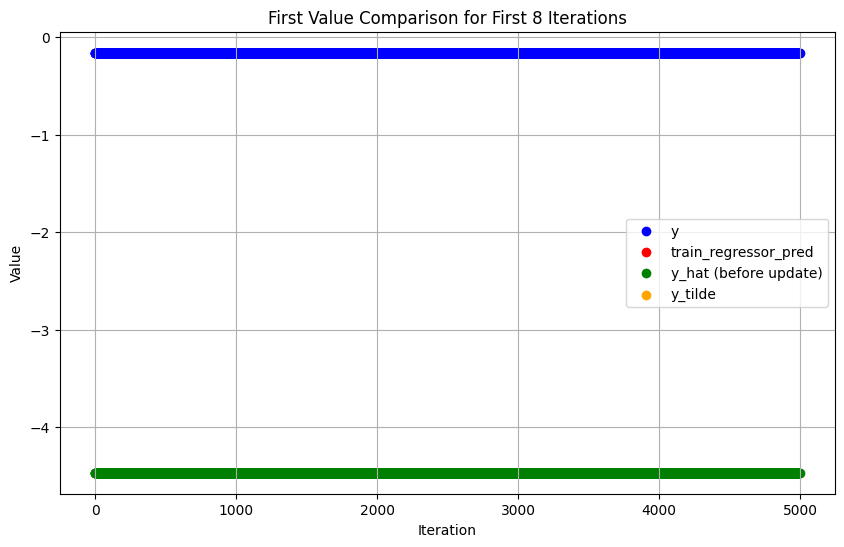

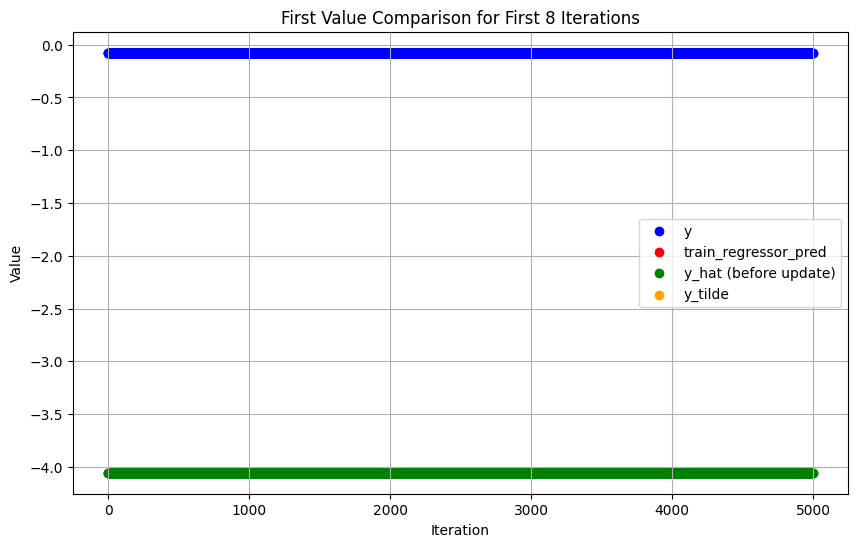

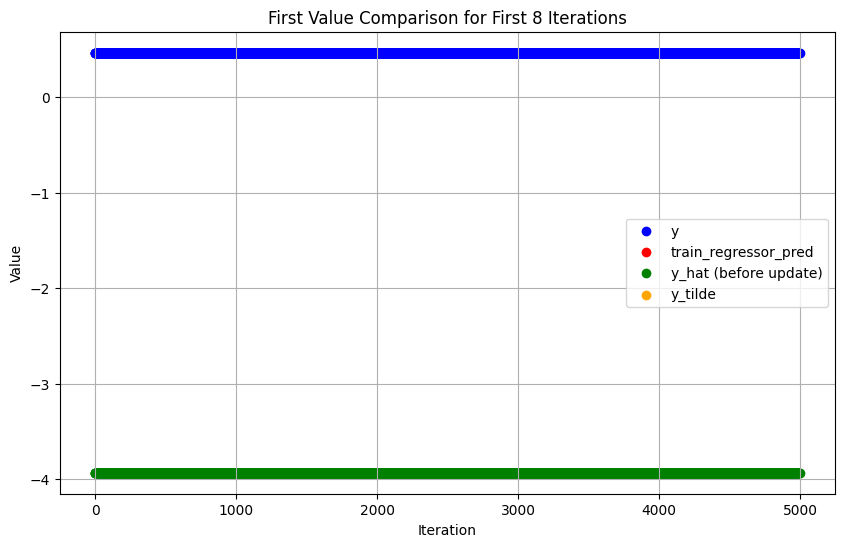

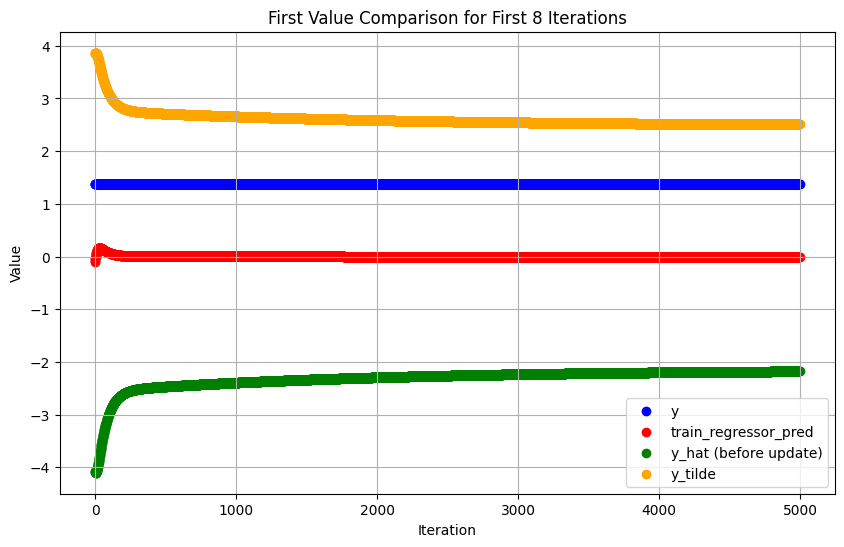

Train F1 Score: 0.7807929868363828, Test F1 Score: 0.786507942110346


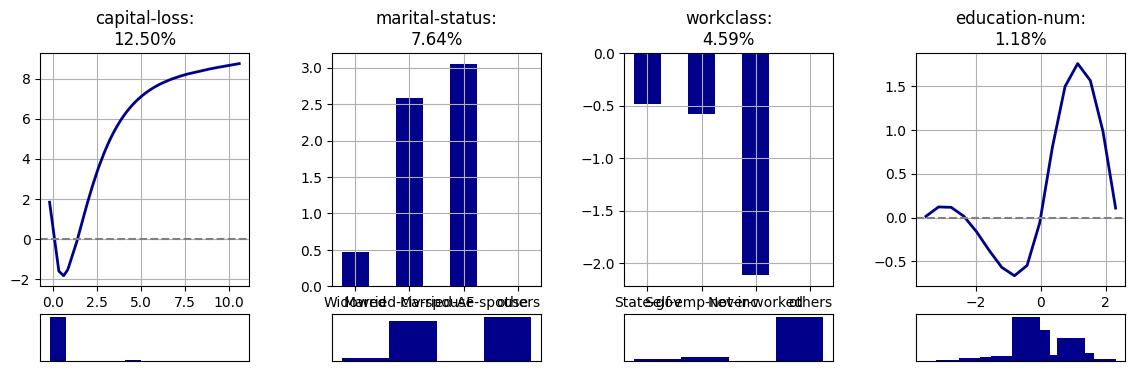

In [6]:
features_to_change = ['education-num', 'workclass', 'marital-status', 'capital-loss']
shape_functions_dict = adapter.model.get_shape_functions_as_dict()
#adapter.plot_single(plot_by_list=['age', 'bmi', 'bp', 'sex', 's1', 's2'])
#adapter.plot_single(plot_by_list=features_to_change)
adapter.model.plot_single(show_n=12)
print(adapter.model)
# this part is already given in the flask application
feature_current_state = {}
for feature in (
        shape_functions_dict):
    name = feature['name']
    y_value = feature['y']
    feature_current_state[name] = y_value

updated_data = {}


for feature in shape_functions_dict:
    name = feature['name']
    x_values = feature['x']
    if name in features_to_change:
        # Simulate user input (by setting negative values to 0); in flask app just use feature_current_state
        if feature["datatype"] == "categorical":
            user_input = -1.5

            feature_current_state[name][0] = -2
            y_values = np.array(feature_current_state[name])
            #y_values = {'x': x_values, 'y': np.where(np.array(feature_current_state[name]) < 0,
            #                                         -2, np.array(feature_current_state[name])), 'datatype': 'categorical'}
            #y_values = np.array(feature_current_state[name])
        else:
            #y_values = np.where(np.array(feature_current_state[name]) < 0, -10, feature_current_state[name])
            y_values = np.array(feature_current_state[name])
            #y_values = np.where(y_values < 0, -3, y_values)
            #updated_data[name] = {'x': x_values.tolist(), 'y': adjusted_y_values.tolist(),
            #                      'datatype': 'numerical'}
            synthetic_data_points_nr = 0
            new_x_values = []
            new_y_values = []
            #transformed_y_values = np.where(y_values < 0.8, 0.9, y_values)
            transformed_y_values = np.where(y_values < 0, -4, y_values)
            if synthetic_data_points_nr > 0:
                for i in range(len(x_values) - 1):
                    new_x_values.append(x_values[i])
                    new_y_values.append(transformed_y_values[i])
                    # Calculate steps for synthetic points
                    x_step = (x_values[i + 1] - x_values[i]) / (synthetic_data_points_nr + 1)
                    y_step = (transformed_y_values[i + 1] - transformed_y_values[i]) / (synthetic_data_points_nr + 1)
                    #
                    for j in range(1, synthetic_data_points_nr + 1):
                        synthetic_x = x_values[i] + j * x_step
                        synthetic_y = transformed_y_values[i] + j * y_step if transformed_y_values[i] != -10 else -10
                        new_x_values.append(synthetic_x)
                        new_y_values.append(synthetic_y)
            #
            #    # Don't forget to add the last original point
                new_x_values.append(x_values[-1])
                new_y_values.append(transformed_y_values[-1])
                x_values = new_x_values
                y_values= new_y_values
            else:
                 y_values = transformed_y_values
                 print("No synthetic points")
            #                       'datatype': 'numerical'}
    else:
        # Use the original 'y' values from shape_functions_dict if there is no user change
        y_values = feature['y']

    if feature['datatype'] == 'numerical':
        updated_data[name] = {'x': x_values, 'y': y_values, 'datatype': 'numerical'}
    else:
        updated_data[name] = {'x': x_values, 'y': y_values, 'datatype': 'categorical'}


# ändern, wenn es in Wesite Code kommt: Nur die Änderungen von features_to_change in feature_current_state übernehmen
# updated_data == feature-current_state; anpassen für kategorische Werte
# Als erstes möchte ich eine Liste von features to change übergeben
# spline, retrain_feature
adapter = adapter.adapt(features_to_change, updated_data, "retrain_feature", X_train, y_train)

y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

adapter.plot_single(plot_by_list=features_to_change)

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter
import torch

if __name__ == "__main__":
    print("Running main script")

    # Load and split the data    X_train, X_test, y_train, y_test, task = load_and_preprocess_data("iris")
    #X_train, X_test, y_train, y_test, task = load_and_preprocess_data("iris")
    #X_train, X_test, y_train, y_test, task = load_and_preprocess_data("titanic")
    X_train, X_test, y_train, y_test, task = load_and_preprocess_data("diabetes")
    #X_train, X_test, y_train, y_test, task = load_and_preprocess_data("bike")

    #X_train, X_test, y_train, y_test, task = load_and_preprocess_data("titanic")

    adapter = ModelAdapter(task)
    adapter.fit(X_train, y_train)

    # Calculate and print mean squared error
    y_train_pred = adapter.predict(X_train)
    y_test_pred = adapter.predict(X_test)

    if task == "regression":
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
    else:
        f1_train = f1_score(y_train, y_train_pred, average='weighted')
        f1_test = f1_score(y_test, y_test_pred, average='weighted')
        print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")



    #features_to_change = ['sepal length (cm)', 'sepal width (cm)',  'petal length (cm)', 'petal width (cm)']
    ##features_to_change = ['sepal length (cm)', 'sepal width (cm)']
    #features_to_change = ['petal length (cm)', 'petal width (cm)']

    #features_to_change = ['petal width (cm)']
    #features_to_change = ['temp']
    features_to_change = ['bmi', 'bp', 'sex']
    #features_to_change = ['Age', 'Pclass', 'Sex']
    #features_to_change = ['education_num', 'workclass', 'marital-status', 'capital-loss']

    # Load feature data
    shape_functions_dict = adapter.model.get_shape_functions_as_dict()
    #adapter.plot_single(plot_by_list=['age', 'bmi', 'bp', 'sex', 's1', 's2'])
    #adapter.plot_single(plot_by_list=features_to_change)
    adapter.model.plot_single(show_n=10)
    print(adapter.model)
    # this part is already given in the flask application
    feature_current_state = {}
    for feature in (
            shape_functions_dict):
        name = feature['name']
        y_value = feature['y']
        feature_current_state[name] = y_value

    updated_data = {}


    for feature in shape_functions_dict:
        name = feature['name']
        x_values = feature['x']
        if name in features_to_change:
            # Simulate user input (by setting negative values to 0); in flask app just use feature_current_state
            if feature["datatype"] == "categorical":
                user_input = -1.5

                feature_current_state[name][0] = -3
                y_values = np.array(feature_current_state[name])
                #y_values = {'x': x_values, 'y': np.where(np.array(feature_current_state[name]) < 0,
                #                                         -2, np.array(feature_current_state[name])), 'datatype': 'categorical'}
                #y_values = np.array(feature_current_state[name])
            else:
                #y_values = np.where(np.array(feature_current_state[name]) < 0, -10, feature_current_state[name])
                y_values = np.array(feature_current_state[name])
                #y_values = np.where(y_values < 0, -3, y_values)
                #updated_data[name] = {'x': x_values.tolist(), 'y': adjusted_y_values.tolist(),
                #                      'datatype': 'numerical'}
                synthetic_data_points_nr = 0
                new_x_values = []
                new_y_values = []
                #transformed_y_values = np.where(y_values < 0.8, 0.9, y_values)
                transformed_y_values = np.where(y_values > 0, 1, y_values)
                if synthetic_data_points_nr > 0:
                    for i in range(len(x_values) - 1):
                        new_x_values.append(x_values[i])
                        new_y_values.append(transformed_y_values[i])
                        # Calculate steps for synthetic points
                        x_step = (x_values[i + 1] - x_values[i]) / (synthetic_data_points_nr + 1)
                        y_step = (transformed_y_values[i + 1] - transformed_y_values[i]) / (synthetic_data_points_nr + 1)
                        #
                        for j in range(1, synthetic_data_points_nr + 1):
                            synthetic_x = x_values[i] + j * x_step
                            synthetic_y = transformed_y_values[i] + j * y_step if transformed_y_values[i] != -10 else -10
                            new_x_values.append(synthetic_x)
                            new_y_values.append(synthetic_y)
                #
                #    # Don't forget to add the last original point
                    new_x_values.append(x_values[-1])
                    new_y_values.append(transformed_y_values[-1])
                    x_values = new_x_values
                    y_values= new_y_values
                else:
                     y_values = transformed_y_values
                     print("No synthetic points")
                #                       'datatype': 'numerical'}
        else:
            # Use the original 'y' values from shape_functions_dict if there is no user change
            y_values = feature['y']

        if feature['datatype'] == 'numerical':
            updated_data[name] = {'x': x_values, 'y': y_values, 'datatype': 'numerical'}
        else:
            updated_data[name] = {'x': x_values, 'y': y_values, 'datatype': 'categorical'}


    # ändern, wenn es in Wesite Code kommt: Nur die Änderungen von features_to_change in feature_current_state übernehmen
    # updated_data == feature-current_state; anpassen für kategorische Werte
    # Als erstes möchte ich eine Liste von features to change übergeben

    adapter = adapter.adapt(features_to_change, updated_data, "spline", X_train, y_train)

    y_train_pred = adapter.predict(X_train)
    y_test_pred = adapter.predict(X_test)
    if task == "regression":
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
    else:
        f1_train = f1_score(y_train, y_train_pred, average='weighted')
        f1_test = f1_score(y_test, y_test_pred, average='weighted')
        print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

    adapter.plot_single(plot_by_list=features_to_change)



Train F1 Score: 0.9242857142857144, Test F1 Score: 0.901010101010101


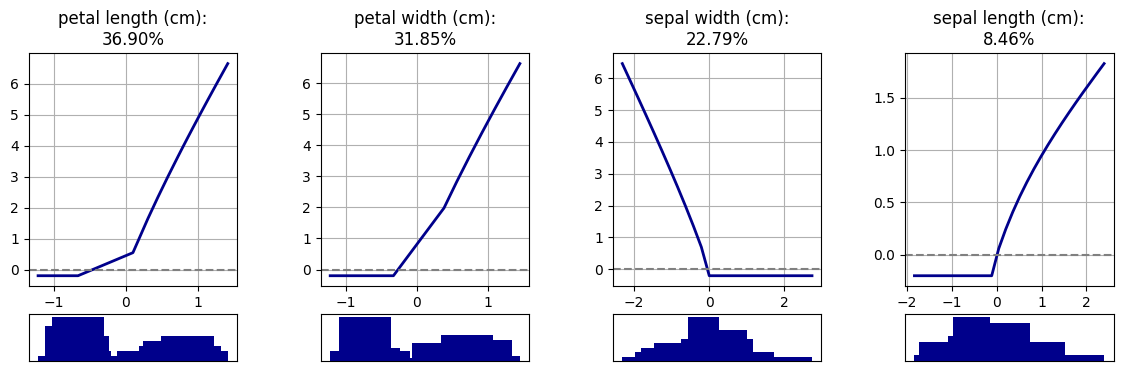

In [3]:
y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

adapter.plot_single(show_n=5)

## Retrain Weights

In [30]:
X_train, X_test, y_train, y_test, task = load_and_preprocess_data()
adapter = ModelAdapter(task)
adapter.fit(X_train, y_train)


In [31]:
features_to_change = ['age', 'bmi', 'bp', 'sex']
shape_functions_dict = adapter.model.get_shape_functions_as_dict()

# this part is already given in the flask application
feature_current_state = {}
for feature in shape_functions_dict:
    name = feature['name']
    y_value = feature['y']
    feature_current_state[name] = y_value

updated_data = {}

for feature in shape_functions_dict:
    name = feature['name']
    x_values = feature['x']

    if name in features_to_change:
        # Simulate user input (by setting negative values to 0); in flask app just use feature_current_state
        if feature["datatype"] == "categorical":
            #y_values = np.array(feature_current_state[name])
            updated_data[name] = {'x': x_values, 'y': np.array([-2]), 'datatype': 'categorical'}
        else:
            y_values = np.where(np.array(feature_current_state[name]) < 0, -0.2, feature_current_state[name])
            updated_data[name] = {'x': x_values, 'y': y_values.tolist(), 'datatype': 'numerical'}

            #y_values = feature_current_state[name]

adapter = adapter.adapt(features_to_change, updated_data, "retrain_feature", X_train, y_train)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [23]:
y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

MSE Train: 1.9934729974122902, MSE Test: 1.9651018934676747


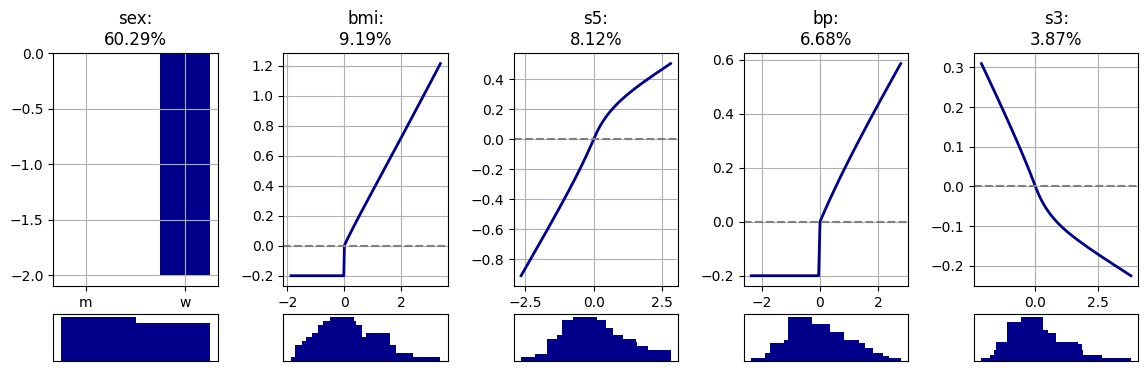

In [24]:
adapter.plot_single(show_n=5)
